In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import re
from pandas import *
import matplotlib.pyplot as plt
%matplotlib inline
from qiime2.plugins import feature_table
from qiime2 import Artifact
from qiime2 import Metadata
import biom
from biom.table import Table
from qiime2.plugins import diversity
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr
%config InlineBackend.figure_formats = ['svg']
from qiime2.plugins.feature_table.methods import relative_frequency
import biom
import qiime2 as q2
import os
import math

## Create relative frequency table

In [ ]:
# tree-filtered-table was created by the validation notebook
!qiime taxa collapse \
  --i-table tree-filtered-table.qza \
  --i-taxonomy taxonomy.qza \
  --p-level 6 \
  --o-collapsed-table phyla-table.qza 

# creates the relative frequency table as a qiime object
!qiime feature-table relative-frequency \
  --i-table phyla-table.qza \
  --o-relative-frequency-table rel-phyla-table.qza

# create the relative frequency table as a biom table
!qiime tools export \
  --input-path rel-phyla-table.qza \
  --output-path exported-rel-table

# create the relative frequency table as a text file
!biom convert -i exported-rel-table/feature-table.biom -o rel-phyla-table-temp.tsv --to-tsv
!echo "$(tail -n +2 rel-phyla-table-temp.tsv)" > rel-phyla-table.tsv

# import metadata and rarefied biom table

In [9]:
# import metadata
meta = q2.Metadata.load('filtered-metadata.qza').to_dataframe()

# import biom table
tbl1 = Artifact.load('inputs/core-metrics-649/rarefied_table.qza').view(biom.Table)

# only keep metadata for samples in rarefied biom table
meta = meta.loc[meta.index.isin(tbl1.ids()), ['host_subject_id', 'sample_preservation_method', 'technical_replicate_number']]
meta.sample_preservation_method

sample_name
14385.K.AssayAssure.20C.vaginalswab.2       assay_assure
14385.K.EtOH.20C.vaginalswab.2                    95etoh
14385.K.AssayAssure.20C.vaginalswab.1       assay_assure
14385.L.EtOH.20C.vaginalswab.2                    95etoh
14385.L.AssayAssure.20C.vaginalswab.1       assay_assure
14385.K.EtOH.20C.vaginalswab.1                    95etoh
14385.N.AssayAssure.20C.vaginalswab.1       assay_assure
14385.M.AssayAssure.20C.vaginalswab.1       assay_assure
14385.M.EtOH.20C.vaginalswab.2                    95etoh
14385.L.AssayAssure.20C.vaginalswab.2       assay_assure
14385.L.None.20C.vaginalswab.1           no_preservative
14385.N.EtOH.20C.vaginalswab.2                    95etoh
14385.N.AssayAssure.20C.vaginalswab.2       assay_assure
14385.K.None.20C.vaginalswab.1           no_preservative
14385.M.AssayAssure.20C.vaginalswab.2       assay_assure
14385.O.AssayAssure.20C.vaginalswab.1       assay_assure
14385.N.None.20C.vaginalswab.1           no_preservative
14385.M.None.20C.va

In [10]:
samples = meta.index.tolist()
pres_methods = [pm for pm in meta.sample_preservation_method.unique() if pm != 'no_preservative']
meta = meta.reset_index()
meta['key'] = 1

base_meta = meta.loc[meta.sample_preservation_method == 'no_preservative']
pres_meta = meta.loc[meta.sample_preservation_method != 'no_preservative']

base_cross_pres = pd.merge(pres_meta, base_meta, on='key').drop('key', 1)
base_cross_pres.loc[(base_cross_pres.host_subject_id_x == base_cross_pres.host_subject_id_y) & (base_cross_pres.host_subject_id_x == 'K')]

,sample_name_x,host_subject_id_x,sample_preservation_method_x,technical_replicate_number_x,sample_name_y,host_subject_id_y,sample_preservation_method_y,technical_replicate_number_y
1,14385.K.AssayAssure.20C.vaginalswab.2,K,assay_assure,2,14385.K.None.20C.vaginalswab.1,K,no_preservative,1
6,14385.K.AssayAssure.20C.vaginalswab.2,K,assay_assure,2,14385.K.None.20C.vaginalswab.2,K,no_preservative,2
21,14385.K.EtOH.20C.vaginalswab.2,K,95etoh,2,14385.K.None.20C.vaginalswab.1,K,no_preservative,1
26,14385.K.EtOH.20C.vaginalswab.2,K,95etoh,2,14385.K.None.20C.vaginalswab.2,K,no_preservative,2
41,14385.K.AssayAssure.20C.vaginalswab.1,K,assay_assure,1,14385.K.None.20C.vaginalswab.1,K,no_preservative,1
46,14385.K.AssayAssure.20C.vaginalswab.1,K,assay_assure,1,14385.K.None.20C.vaginalswab.2,K,no_preservative,2
101,14385.K.EtOH.20C.vaginalswab.1,K,95etoh,1,14385.K.None.20C.vaginalswab.1,K,no_preservative,1
106,14385.K.EtOH.20C.vaginalswab.1,K,95etoh,1,14385.K.None.20C.vaginalswab.2,K,no_preservative,2


## import data to plot

In [11]:
# import data to plot (relative abundance table collapsed to the genus level) 
fec6 = pd.read_csv('rel-phyla-table.tsv', sep='\t', index_col=0)
fec6 = fec6[samples]

In [12]:
# melt the table so that we can use it later as we want
melt = fec6.unstack()
fec6s = pd.DataFrame(melt)

In [13]:
fec6s.reset_index(inplace=True)
fec6s.rename(columns={'level_0':'sample','#OTU ID':'taxa',0:'counts'}, inplace=True)
fec6s = fec6s.pivot(index='sample', columns='taxa', values='counts')

In [14]:
fec6s

taxa,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Microtrichales;f__Ilumatobacteraceae;g__CL500-29_marine_group,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomycetaceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Trueperella,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Alloscardovia,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Actinobacillus,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__SAR86_clade;f__SAR86_clade;g__SAR86_clade,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Thiothrix,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Jonquetella,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter
sample,,,,,,,,,,,,,,,,,,,,,
14385.K.AssayAssure.20C.vaginalswab.1,0.000000,0.000000,0.000000,0.000202,0.000000,0.000662,0.000000,0.000086,0.000000,0.000058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058,0.000000,0.000000,0.010293,0.000000
14385.K.AssayAssure.20C.vaginalswab.2,0.000000,0.000000,0.000000,0.000563,0.000000,0.000145,0.000000,0.000454,0.000000,0.000345,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015089,0.000000
14385.K.EtOH.20C.vaginalswab.1,0.000000,0.000000,0.000133,0.000000,0.000000,0.000875,0.000000,0.000247,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000304,0.000000,0.000000,0.008141,0.000000
14385.K.EtOH.20C.vaginalswab.2,0.000000,0.000000,0.000023,0.000000,0.000000,0.000160,0.000000,0.000126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000023,0.000000,0.000000,0.002583,0.000000
14385.K.None.20C.vaginalswab.1,0.000000,0.000000,0.000000,0.000019,0.000000,0.000124,0.000000,0.000067,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001769,0.000000
14385.K.None.20C.vaginalswab.2,0.000000,0.000000,0.000000,0.000089,0.000000,0.001630,0.000000,0.000193,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019012,0.000000
14385.L.AssayAssure.20C.vaginalswab.1,0.000000,0.000000,0.000292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000013,0.000000,0.001221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14385.L.AssayAssure.20C.vaginalswab.2,0.000000,0.000000,0.000266,0.000000,0.000000,0.000028,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000210,0.000070,0.000238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14385.L.EtOH.20C.vaginalswab.1,0.000000,0.000000,0.000333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000042,0.00

In [15]:
fec6s.loc[['14385.K.AssayAssure.20C.vaginalswab.1']]

taxa,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Microtrichales;f__Ilumatobacteraceae;g__CL500-29_marine_group,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomycetaceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Trueperella,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Alloscardovia,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Actinobacillus,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__SAR86_clade;f__SAR86_clade;g__SAR86_clade,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Thiothrix,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Jonquetella,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter
sample,,,,,,,,,,,,,,,,,,,,,
14385.K.AssayAssure.20C.vaginalswab.1,0.0,0.0,0.0,0.000202,0.0,0.000662,0.0,0.000086,0.0,0.000058,...,0.0,0.0,0.0,0.0,0.0,0.000058,0.0,0.0,0.010293,0.0


## Correlation graphs
### compare 95etoh vs no_preservative and assay_assure vs no_preservative

In [16]:
# meta = meta.reset_index()
# s_rep = pd.concat([meta]*2, ignore_index=True)#.groupby(['host_subject_id', 'sample_preservation_method']).sample(n=1, random_state=1)
# s_rep['orig'] = s_rep.duplicated(subset=['host_subject_id', 'sample_preservation_method', 'technical_replicate_number']).astype(str)
# # s_rep = meta

# #list of metadata preservative subgroups
# pres_sep = [] 
# bl = []


# #list of baselines
# base_df = s_rep.loc[s_rep.sample_preservation_method == 'no_preservative']

# #creat metadata subgroups
# for preservation, preservation_df in s_rep.groupby('sample_preservation_method'):
#     if preservation != 'no_preservative':
#         pres_sep.append(preservation_df)
#         bl.append(base_df)
    
# #list of preservative and temperature subgroups with their baseline samples
# subsets_w_bl = {}
# for etoh70_df, etoh70_bl in zip(pres_sep, bl):
#     #create list of temperature subgroups with their baseline samples
#     for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
#                                                            'sample_storage_temp_treatment']):
#         new_df = pd.concat([etoh70_bl,temperature_df])
#         subsets_w_bl[(pres, temp)] = new_df
subsets_w_bl = {}
for pm in pres_methods:
    subsets_w_bl[pm] = base_cross_pres.loc[base_cross_pres.sample_preservation_method_x == pm]

assay_assure


(0.9859445680323868, 0.0)

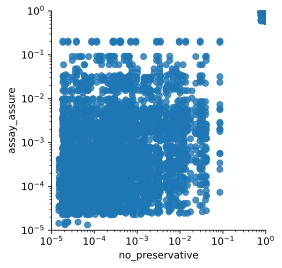

In [17]:
list_of_lists = []

for key, value in subsets_w_bl.items():
    print(key)
    base_tax = fec6s.loc[value.sample_name_y]
    pres_tax = fec6s.loc[value.sample_name_x]
    data = {'no_preservative': base_tax.to_numpy().flatten(),
            key: pres_tax.to_numpy().flatten()}
    fecpiv_no_na = pd.DataFrame(data=data)

    # check pearson correlation
    x = fecpiv_no_na['no_preservative']
    y = fecpiv_no_na[key]
    corr = stats.pearsonr(x, y)
    int1, int2 = corr
    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    
    list1 = []
    list1.append(corr_rounded)
    list1.append(key)
    list_of_lists.append(list1)
    
    #make correlation plots
    ax=sns.lmplot(x='no_preservative',y=key, data=fecpiv_no_na, height=3.8, logx=True, fit_reg=True)
    ax.set(yscale='log')
    ax.set(xscale='log')
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    break
#     plt.title(string + ' (%s)' %corr_str)

corr

In [ ]:
fecpiv_no_na

In [ ]:
df = pd.DataFrame(list_of_lists, columns = ['Correlation', 'Preservative']) 

In [ ]:
splot = sns.catplot(y="Correlation", x="Preservative", kind='bar',
                    data=df)  

splot.set(ylim=(0, 1))
splot.savefig('correlation_none_fresh_amb_bl.png')
splot.savefig('correlation_none_fresh_amb_bl.svg', format='svg', dpi=1200)

In [22]:
# import metadata
meta = q2.Metadata.load('filtered-metadata.qza').to_dataframe()

# import biom table
tbl1 = Artifact.load('inputs/core-metrics-649/rarefied_table.qza').view(biom.Table)

# only keep metadata for samples in rarefied biom table
meta = meta.loc[meta.index.isin(tbl1.ids())]
meta.sample_preservation_method

# import data to plot (relative abundance table collapsed to the genus level) 
fec6 = pd.read_csv('rel-phyla-table.tsv', sep='\t', index_col=0)

# melt the table so that we can use it later as we want
melt = fec6.unstack()
fec6s = pd.DataFrame(melt)

fec6s.reset_index(inplace=True)
fec6s.rename(columns={'level_0':'sample','#OTU ID':'taxa',0:'counts'}, inplace=True)

In [23]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation != 'no_preservative':
        pres_sep.append(preservation_df)

for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'no_preservative':
        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}
for etoh70_df, etoh70_bl in zip(pres_sep, bl):
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [24]:
fec6.sum()

14385.K.AssayAssure.20C.vaginalswab.2    1.0
14385.K.EtOH.20C.vaginalswab.2           1.0
14385.K.AssayAssure.20C.vaginalswab.1    1.0
14385.L.EtOH.20C.vaginalswab.2           1.0
14385.L.AssayAssure.20C.vaginalswab.1    1.0
14385.K.EtOH.20C.vaginalswab.1           1.0
14385.N.AssayAssure.20C.vaginalswab.1    1.0
14385.M.AssayAssure.20C.vaginalswab.1    1.0
14385.M.EtOH.20C.vaginalswab.2           1.0
14385.L.AssayAssure.20C.vaginalswab.2    1.0
14385.L.None.20C.vaginalswab.1           1.0
14385.N.EtOH.20C.vaginalswab.2           1.0
14385.N.AssayAssure.20C.vaginalswab.2    1.0
14385.K.None.20C.vaginalswab.1           1.0
14385.M.AssayAssure.20C.vaginalswab.2    1.0
14385.O.AssayAssure.20C.vaginalswab.1    1.0
14385.N.None.20C.vaginalswab.1           1.0
14385.M.None.20C.vaginalswab.1           1.0
14385.N.EtOH.20C.vaginalswab.1           1.0
14385.L.EtOH.20C.vaginalswab.1           1.0
14385.M.EtOH.20C.vaginalswab.1           1.0
14385.O.AssayAssure.20C.vaginalswab.2    1.0
14385.N.No

(0.9871528926728385, 0.0)

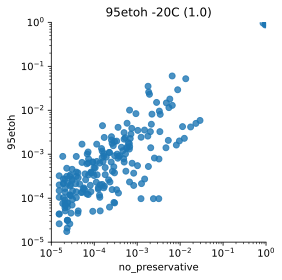

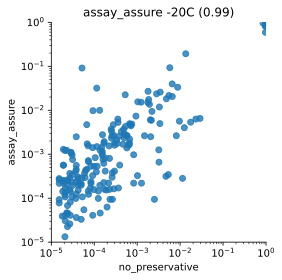

In [25]:
for key, value in subsets_w_bl.items():
    k, _ = key
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'sample_preservation_method'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='sample_preservation_method', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['no_preservative']
    y = fecpiv_no_na[k]
    corr = stats.pearsonr(x, y)
    int1, int2 = corr
    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    
    #make correlation plots
    ax=sns.lmplot(x='no_preservative',y=k,data=fecpiv_no_na, height=3.8, logx=True, fit_reg=True)
    ax.set(yscale='log')
    ax.set(xscale='log')
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    plt.title(string + ' (%s)' %corr_str)

corr